# Sommaire <a name=0 ></a>
- [Introduction](#1)
- [I. Chargement des Données](#2)
- [II. Préparation des Données pour la Modélisation](#3)
- [III. Nettoyage des Données](#4)
- [IV. Analyse Exploratoire des Données](#5)


# Introduction<a name=1 ></a>

Le notebook qui suit a été rédigé dans le cadre de la modélisation de la segmentation client pour l'entreprise Olist. En tant que consultant, notre objectif est de développer une segmentation exploitable par l'équipe Marketing, permettant de différencier les bons clients des moins bons en termes de commandes et de satisfaction. Pour ce faire, nous explorerons différentes approches de modélisation, incluant mais ne se limitant pas à la segmentation RFM (Récence, Fréquence, Montant), ainsi que des mesures de satisfaction et d'autres possibilités.

Pour cela, nous mettons à disposition un ensemble de 4 documents distincts, dont 3 rapport Python, conformément aux requêtes de l'entreprise Olist. Ces 3 rapports constituent les 3 étapes principales qui ont été menées au cours de notre mission, à savoir : 
- Chargement et Exploration des Données : Il s'agit du notebook ici-présent. Nous commencerons par charger et explorer les données disponibles pour comprendre leur structure et leur contenu. Ensuite, nous préparerons les données pour l'analyse, en traitant les valeurs manquantes et en effectuant des transformations nécessaires. Enfin, ce notebook servira spécifiquement d'analyse exploratoire des données.
- Modélisation et Segmentation : Nous appliquerons différentes techniques de segmentation et évaluerons leur pertinence pour répondre aux besoins d'Olist.
- Recommandations : Enfin, nous proposerons des recommandations sur la fréquence de mise à jour de la segmentation pour maintenir sa pertinence.

# I. Chargement des Données<a name=2 ></a>

Pour cette analyse, une requête SQL a été préalablement conçue pour effectuer le feature engineering nécessaire, combinant plusieurs tables de la base de données afin d'extraire des informations consolidées sur les clients. Le code suivant nous permettra de charger ces données à partir de la base de données SQLite d'Olist et de les préparer pour l'analyse :

In [1]:
import sqlite3
import pandas as pd

# Connexion à la base de données
conn = sqlite3.connect("olist.db")

# Exécution de la requête SQL pour récupérer les données
sql_query = pd.read_sql_query("""
WITH location AS (
    SELECT 
        geolocation_zip_code_prefix, 
        AVG(geolocation_lat) AS latt, 
        AVG(geolocation_lng) AS long 
    FROM geoloc
    GROUP BY geolocation_zip_code_prefix),
pricing AS (
    SELECT 
        order_id, 
        SUM(price) AS sales, 
        AVG(freight_value / (price + freight_value)) AS shipping, 
        SUM(price + freight_value) AS total
    FROM (
        SELECT DISTINCT 
            order_items.order_id, 
            order_items.seller_id, 
            order_items.price, 
            order_items.freight_value 
        FROM order_items)
    GROUP BY order_id)
SELECT 
    customer_unique_id, 
    COUNT(*) AS total_purchase, 
    latt, 
    long, 
    customer_state,
    (julianday(date('2018-10-17')) - julianday(MIN(order_purchase_timestamp))) / 30.42 AS seniority,
    MAX(order_purchase_timestamp) AS latest_purchase, 
    AVG(julianday(order_estimated_delivery_date) - julianday(order_purchase_timestamp)) AS delivery_time,
    AVG(julianday(order_delivered_customer_date) - julianday(order_estimated_delivery_date)) AS delay,
    sales, 
    shipping, 
    total, 
    AVG(review_score) AS average_score
FROM customers
LEFT JOIN location ON customers.customer_zip_code_prefix = location.geolocation_zip_code_prefix
LEFT JOIN orders ON customers.customer_id = orders.customer_id
LEFT JOIN pricing ON orders.order_id = pricing.order_id
LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
WHERE orders.order_status = 'delivered'
GROUP BY customer_unique_id
ORDER BY total_purchase DESC;
""", conn)

# Conversion des résultats en DataFrame
olist = pd.DataFrame(sql_query)

# Affichage du DataFrame final
olist

,customer_unique_id,total_purchase,latt,long,customer_state,seniority,latest_purchase,delivery_time,delay,sales,shipping,total,average_score
0,8d50f5eadf50201ccdcedfb9e2ac8455,15,-23.618666,-46.639583,SP,15.944901,2018-08-20 19:14:26,12.683943,-8.645721,23.40,0.394723,38.66,5.000000
1,3e43e6105506432c953e165fb2acf44c,9,-24.008923,-46.419125,SP,12.926135,2018-02-27 18:36:39,22.488942,-8.359986,109.90,0.111488,123.69,2.777778
2,ca77025e7201e3b30c44b472ff346268,7,-8.125613,-34.902732,PE,12.244442,2018-06-01 11:38:29,31.806925,-14.996612,74.99,0.203928,94.20,5.000000
3,b4e4f24de1e8725b74e4a1f4975116ed,7,-21.765785,-43.330555,MG,7.739966,2018-03-30 20:48:54,22.846212,-8.357280,24.90,0.379052,40.10,4.142857
4,6469f99c1f9dfae7733b25662e7f1782,7,-23.965227,-46.343581,SP,12.917700,2018-06-28 00:43:34,17.479845,-13.214352,24.90,0.237366,32.65,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,0004aac84e0df4da2b147fca70cf8255,1,-23.505548,-47.469705,SP,11.051170,2017-11-14 19:45:42,20.176597,-7.035463,180.00,0.085784,196.89,5.000000
93354,0000f6ccb0745a6a4b88665a16c9f078,1,-1.312214,-48.483159,PA,12.134979,2017-10-12 20:29:41,31.146053,-11.108970,25.99,0.404172,43.62,4.000000
93355,0000f46a3911fa3c0805444483337064,1,-27.542880,-48.633426,SC,19.234763,2017-03-10 21:05:03,27.121493,-1.389734,69.00,0.199722,86.22,3.000000
93356,0000b849f77a49e4a4ce2b2a4ca5be3f,1,-23.559115,-46.787626,SP,5.342989,2018-05-07 11:11:27,7.533715,-4.248125,18.90,0.304892,27.19,4.000000


Passons maintenant à la préparation et à l'exploration des données pour notre analyse de segmentation.

# II. Préparation des Données pour la Modélisation<a name=3 ></a>

Dans cette section, nous allons explorer les données extraites et effectuer les premières étapes de préparation. Nous commencerons par définir l'index du DataFrame, afficher des informations de base sur les données et effectuer quelques transformations pour assurer la qualité et la cohérence des données.

Commençons par définir l'index du DataFrame sur customer_unique_id et obtenir un aperçu des informations de base :

In [2]:
# Définir la colonne 'customer_unique_id' comme index du DataFrame
olist = olist.set_index('customer_unique_id')

# Afficher des informations sur le DataFrame, telles que le type des colonnes et les valeurs manquantes
olist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93358 entries, 8d50f5eadf50201ccdcedfb9e2ac8455 to 0000366f3b9a7992bf8c76cfdf3221e2
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   total_purchase   93358 non-null  int64  
 1   latt             93104 non-null  float64
 2   long             93104 non-null  float64
 3   customer_state   93358 non-null  object 
 4   seniority        93358 non-null  float64
 5   latest_purchase  93358 non-null  object 
 6   delivery_time    93358 non-null  float64
 7   delay            93350 non-null  float64
 8   sales            93358 non-null  float64
 9   shipping         93358 non-null  float64
 10  total            93358 non-null  float64
 11  average_score    92755 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 9.3+ MB


Nous pouvons d'ores et déjà observer ici que certaines colonnes ne sont pas remplies à 100%. Or, il s'agit d'une des conditions sine qua non dans l'application d'un modèle de clustering ou de prédiction, quel qu'il soit. Ainsi nous allons effectuer les actions suivantes : 
- colonnes "latt" & "long" : nous allons remplir les valeurs manquantes par leurs valeurs médianes respectives selon l'état fédéral du Brésil dans lequel se situe le client (colonne "customer_state")
- colonne "delay" : nous allons remplir les valeurs manquantes par 0. En effet, nous partons de l'hypothèse que les articles achetés on été livrés ni en retard, ni en avance, mais pile le jour prévu.
- colonne average_score : nous allons remplir les valeurs manquantes par 2.5. En effet, l'entreprise Olist est ici noté sur une échelle de 0 à 5. Le score de 2.5 constituant ainsi la note moyenne, l'implantation de ce chiffre sur 603 clients supplémentaires constituera un impact minimal sur les potientielles tendances que nous serons amenés à observer dans ce notebook.

Une fois ces manipulations faites, intéressons-nous à la colonne "latest_purchase". Comme vu sur le tableau ci-dessus, cette dernière a été importée au format object, alors qu'il s'agit de données temporelles. Nous allons donc convertir ce feature au format datetime.

Une fois, nous serons dès lors en mesure d'effectuer une première analyse de l'ensemble de la clientèle, voire d'établir un profil type:

In [3]:
# Convertir la colonne 'latest_purchase' en format datetime
olist['latest_purchase'] = pd.to_datetime(olist['latest_purchase'], format="%Y-%m-%d %H:%M:%S")

# Remplacer les valeurs manquantes dans la colonne 'delay' par 0
olist.loc[olist['delay'].isna(), 'delay'] = 0

# Remplacer les valeurs manquantes dans la colonne 'average_score' par 2.5
olist.loc[olist['average_score'].isna(), 'average_score'] = 2.5

# Liste des états clients, triée par fréquence d'apparition
customer_state = list(olist['customer_state'].value_counts().index)

# Remplir les valeurs manquantes de latitude et longitude par la médiane de chaque état
for state in customer_state:
    olist.loc[(olist['customer_state'] == state) & (olist['latt'].isna()), 'latt'] = \
        olist.loc[olist['customer_state'] == state, 'latt'].median()
    olist.loc[(olist['customer_state'] == state) & (olist['long'].isna()), 'long'] = \
        olist.loc[olist['customer_state'] == state, 'long'].median()

# Afficher les statistiques descriptives du DataFrame
olist.describe()

,total_purchase,latt,long,seniority,latest_purchase,delivery_time,delay,sales,shipping,total,average_score
count,93358.000000,93358.000000,93358.000000,93358.000000,93358,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000
mean,1.039086,-21.177536,-46.187512,9.483469,2018-01-04 03:47:36.045362944,23.717931,-11.149249,128.558509,0.208574,149.288732,4.142987
min,1.000000,-33.689948,-72.668881,1.590223,2016-09-15 12:16:38,2.010451,-146.016123,0.850000,0.000000,9.590000,1.000000
25%,1.000000,-23.589413,-48.119196,5.404576,2017-09-17 18:25:15,18.334660,-16.226823,43.000000,0.116608,58.230000,4.000000
50%,1.000000,-22.922759,-46.633258,8.866423,2018-01-23 00:12:12.500000,23.230758,-11.724795,79.900000,0.183256,98.350000,5.000000
75%,1.000000,-20.077863,-43.625086,13.094881,2018-05-07 17:22:34.750000128,28.391814,-6.390862,143.000000,0.274992,166.290000,5.000000
max,15.000000,42.184003,-8.723762,25.032493,2018-08-29 15:00:37,155.135463,188.975081,6735.000000,0.955451,6929.310000,5.000000
std,0.249776,5.617482,4.056552,5.032915,NaN,8.713188,10.141616,193.012510,0.125369,200.586182,1.282792


A partir de ce tableau, nous d'ores et déjà définir un profil de type de client de Olist dont les caractéristiques sont les suivantes:
- n'a effectué qu'une seule opération d'achat
- le coût de son opération d'achat reste dans l'ensemble minime (140-180 reals, soit l'équivalent d'environ 20-30 euros)
- a reçu son produit en avance par rapport à la date de livraison prévue
- raison pour laquelle il est globalement satisfait de la prestation

Nous pouvons maintenant démarrer la deuxième étape de notre notebook, à savoir celui du nettoyage. Nous procéderons tout d'abord de manière verticale, par le traitement des colonnes, puis de manière horizontale, en nous intéressant aux valeurs desdites colonnes dans leurs globalités.

# III. Nettoyage des Données<a name=4 ></a>

Nous allons donc tout d'abord nous intéresser aux différents features. Cela passe par la compréhension des relations entre les différentes variables quantitatives. Pour cela, nous allons visualiser la matrice de corrélation :

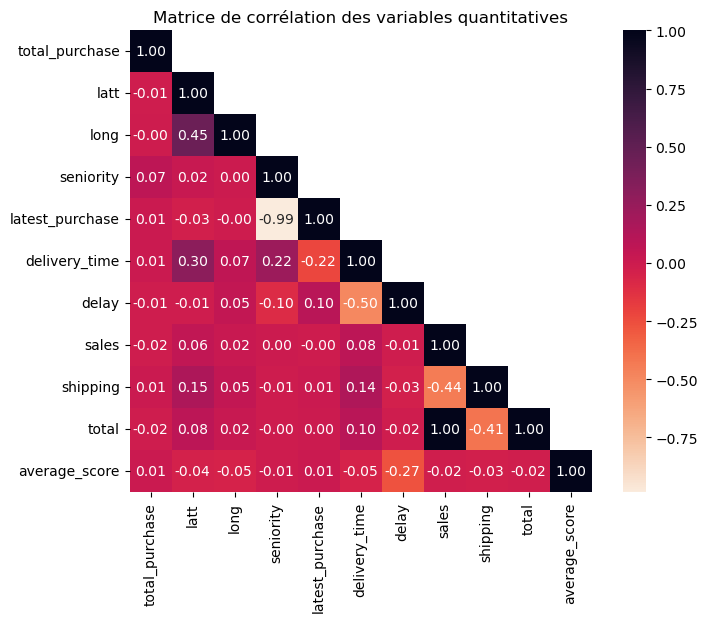

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sélection des colonnes quantitatives du DataFrame (non de type 'object')
elements = [col for col in olist.columns if olist[col].dtype != object]

# Configuration de la taille de la figure pour l'affichage de la heatmap
plt.figure(figsize=(8, 6))

# Choix de la palette de couleurs pour la heatmap
cmap = sns.cm.rocket_r

# Création d'un masque pour n'afficher que la partie inférieure de la matrice de corrélation
mask = np.triu(np.ones_like(olist[elements].corr(), dtype=bool), k=1)

# Affichage de la matrice de corrélation avec annotations
sns.heatmap(olist[elements].corr(), mask=mask, annot=True, cmap=cmap, fmt=".2f", square=True)

# Titre de la heatmap
plt.title('Matrice de corrélation des variables quantitatives')

# Affichage de la figure
plt.show()

Nous voyons ici que dans l'ensemble, les features sont indépendantes. Nous pouvons cependant noter 2 exceptions particulièrement significatives : 
- Au niveau des colonnes "seniority" et "latest_purchase", qui sont quasi-totalement anti-corrélées. Cela n'a rien de surprenant, étant donné que la variable "senority" a été développée au préalable en feature engineering à partir même des données présentes dans "latest_purchase". Il n'est donc pas forcément utile de garder ces deux colonnes à la fois. Celle de "latest_purchase" est davantage essentielle vis-à-vis de notre démarche de clusterisation, et présente des valeurs nettement plus précises. C'est pourquoi nous allons supprimer la colonnes "seniority".
- Au niveau des colonnes "sales" et "total", qui sont corrélées à 100%. Cela s'explique par le fait que la colonne "total" représente l'addition du prix d'achat et des frais de port. La colonne "sales" représente ainsi un des éléments qui constitue les valeurs de la colonne "total". Là-aussi, il n'est pas nécessaire de les garder tout deux. Nous allons ici conserver la colonne total car elle représente les sommes réelles dépensées par chaque client. De plus, nous connaissons le pourcentage des frais de port de chaque opération d'achat grâce à la colonne "shipping". Il est donc possible de calculer de nouveau, si besoin, les montants des opérations d'achats disponibles sur "sales". C'est pourquoi nous pouvons sans probleme supprimer la colonnes "sales".

Maintenant que nous avons opéré notre nettoyage vertical de notre dataset, nous pouvons dès lors nous pencher vers un nettoyage horizontal. Pour cela, nous allons effectuer une opération d'identification de valeurs abérrantes. Nous aviserons par la suite des actions à effectuer selon les résultats de ces opérations. Ici, nous appliquons la méthode des écarts interquartiles en déterminant un seuil large de 5% :

In [5]:
# Suppression des colonnes 'sales' et 'seniority' du DataFrame
olist.drop(columns=['sales','seniority'], inplace=True)

# Mise à jour de la liste des éléments en supprimant les colonnes retirées
elements.remove('sales')
elements.remove('seniority')

# Conversion de la colonne 'latest_purchase' en datetime
olist['latest_purchase'] = pd.to_datetime(olist['latest_purchase'])

# Définir la date de référence pour calculer la durée depuis la dernière opération d'achat
reference_date = pd.Timestamp("2018-10-17")

# Calculer le nombre de jours depuis la dernière opération d'achat
olist['latest_purchase_numeric'] = (reference_date - olist['latest_purchase']) // pd.Timedelta('1D')

# Mise à jour de la liste des éléments
elements.remove('latest_purchase')
elements.append('latest_purchase_numeric')

# Dictionnaire pour stocker les outliers pour chaque colonne
outliers = {}

# Identifier les outliers pour chaque colonne
for i in elements:
    outliers[i] = pd.DataFrame()
    for j in olist['customer_state'].unique():
        group_data = olist[olist['customer_state'] == j]
        
        # Calcul des quantiles pour identifier les outliers
        Q1 = group_data[i].quantile(0.05)
        Q3 = group_data[i].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Détection des outliers
        outliers_for_column = group_data[(group_data[i] < lower_bound) | (group_data[i] > upper_bound)]
        outliers[i] = pd.concat([outliers[i], outliers_for_column])
        
    # Affichage du nombre d'outliers pour chaque colonne
    print(i,":",outliers[i].shape[0])

total_purchase : 2891
latt : 44
long : 37
delivery_time : 51
delay : 131
shipping : 1
total : 925
average_score : 0
latest_purchase_numeric : 0


Ce que nous observons ici, c'est la présence d'un nombre de valeurs abérrantes très peu significatif. De plus, comme vu précédemment dans le tableau "describe", bien que ces valeurs soient largement plus élevées que le reste du dataset, elles ne reflètent en aucun cas des cas de figures impossibles. A titre d'exemple, nous savions d'ores et déjà que plus de 97% des clients n'ont effectué qu'une seule et unique opération d'achat au cours du laps de temps donné ici.

Ainsi, les seules valeurs abérrantes que nous traiterons par la suite sont celles des variables "latt" et "long". En effet, ce sont les seuls variables qui affichent des valeurs abérrantes qui, lorsqu'elles sont étudiées, démontrent qu'elles sortent largement de la surface géographique du Brésil. Nous remplacerons donc ici les valeurs abérrantes par les médianes des nos 2 variables calculées en fonction de l'état fédéral auquel est rattaché au client, soit de la même manière que nous avons traité les valeurs manquantes.

Une fois fait, nous pouvons démarrer une courte analyse exploratoire de nos données dont la visualisation sera faite de manière géographique.

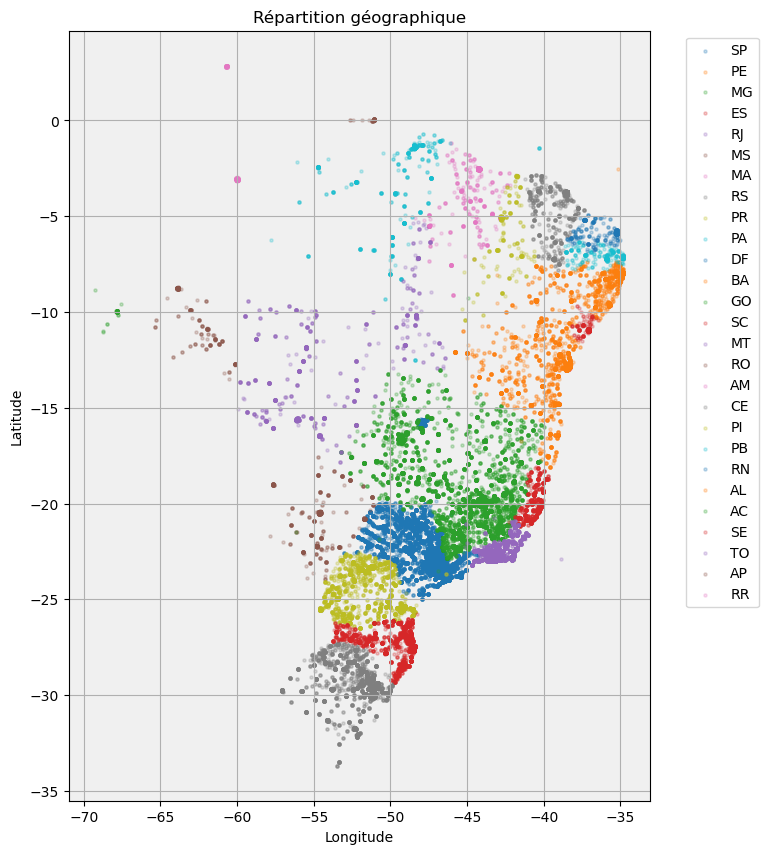

In [6]:
# Récupération des index des outliers pour 'latt' et 'long'
latt = outliers['latt'].index
long = outliers['long'].index

# Remplacement des valeurs manquantes pour 'latt' et 'long' par la médiane par état
for state in olist['customer_state'].unique():
    
    # Mise à jour des valeurs 'latt' pour les outliers
    olist.loc[(olist.index.isin(latt)) & (olist['customer_state'] == state), 'latt'] = \
        olist.loc[olist['customer_state'] == state, 'latt'].median()
    
    # Mise à jour des valeurs 'long' pour les outliers
    olist.loc[(olist.index.isin(long)) & (olist['customer_state'] == state), 'long'] = \
        olist.loc[olist['customer_state'] == state, 'long'].median()

# Configuration de la taille de la figure pour le graphique
plt.figure(figsize=(7.5, 10))

# Configuration des labels et du titre du graphique
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Répartition géographique")

# Initialisation de la légende
legend_handles = []

# Définition de la couleur de fond du graphique
plt.gca().set_facecolor('#F0F0F0')

# Création des scatter plots pour chaque état
for state in olist['customer_state'].unique():
    handle = plt.scatter(
        olist['long'][olist['customer_state'] == state],
        olist['latt'][olist['customer_state'] == state],
        alpha=0.25,
        s=5,
        label=f'{state}')
    legend_handles.append(handle)

# Affichage de la légende en dehors du graphique
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajout de la grille au graphique
plt.grid()

# Affichage du graphique
plt.show()

## IV. Analyse Exploratoire des Données<a name=5 ></a>

Ici, nous allons rapidement visualiser la répartition géographique des clients par ventes, frais de port, délais de livraison, retards, ancienneté et notes moyennes :

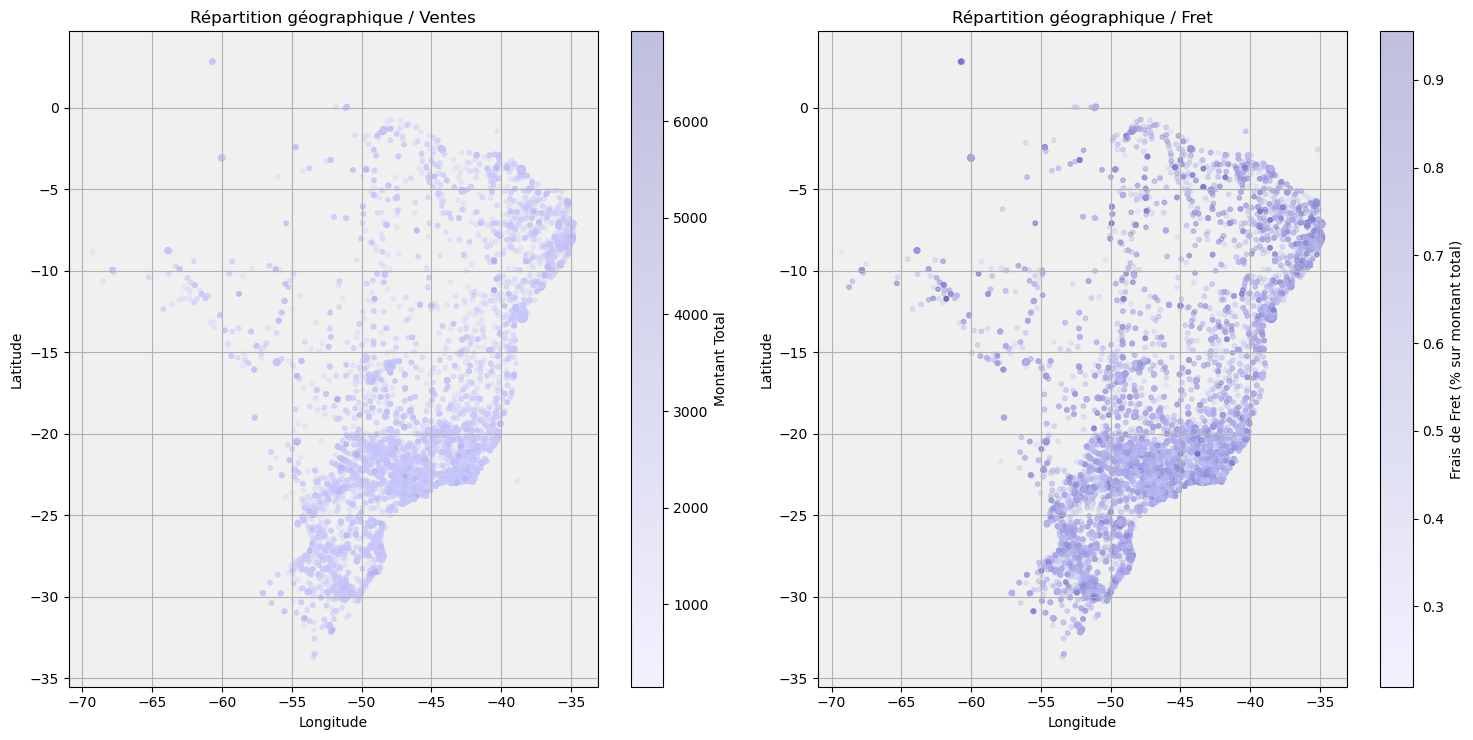

In [7]:
from matplotlib.colors import LinearSegmentedColormap

# Définir une palette de couleurs personnalisée
colors = [(0.8, 0.8, 1), (0, 0, 0.5)]
custom_cmap = LinearSegmentedColormap.from_list('custom_blue', colors)

# Création de la figure avec une taille spécifique
plt.figure(figsize=(15, 7.5))

# Premier sous-plot : Répartition géographique / Ventes
plt.subplot(1, 2, 1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Répartition géographique / Ventes")
plt.gca().set_facecolor('#F0F0F0')

# Filtrer les données pour afficher uniquement les ventes au-dessus de la moyenne
oliste = olist.loc[olist['total'] > olist['total'].mean()]

# Création du scatter plot pour les ventes
scatter = plt.scatter(
    oliste['long'],
    oliste['latt'],
    c=oliste['total'],
    cmap=custom_cmap,
    alpha=0.25,
    s=10)
plt.colorbar(scatter, label='Montant Total')
plt.grid()

# Deuxième sous-plot : Répartition géographique / Fret
plt.subplot(1, 2, 2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Répartition géographique / Fret")
plt.gca().set_facecolor('#F0F0F0')

# Filtrer les données pour afficher uniquement les frais de fret au-dessus de la moyenne
oliste = olist.loc[olist['shipping'] > olist['shipping'].mean()]

# Création du scatter plot pour les frais de fret
scatter = plt.scatter(
    oliste['long'],
    oliste['latt'],
    c=oliste['shipping'],
    cmap=custom_cmap,
    alpha=0.25,
    s=10)
plt.colorbar(scatter, label='Frais de Fret (% sur montant total)')
plt.grid()

# Ajustement automatique des sous-plots pour éviter le chevauchement
plt.tight_layout()

# Affichage de la figure
plt.show()

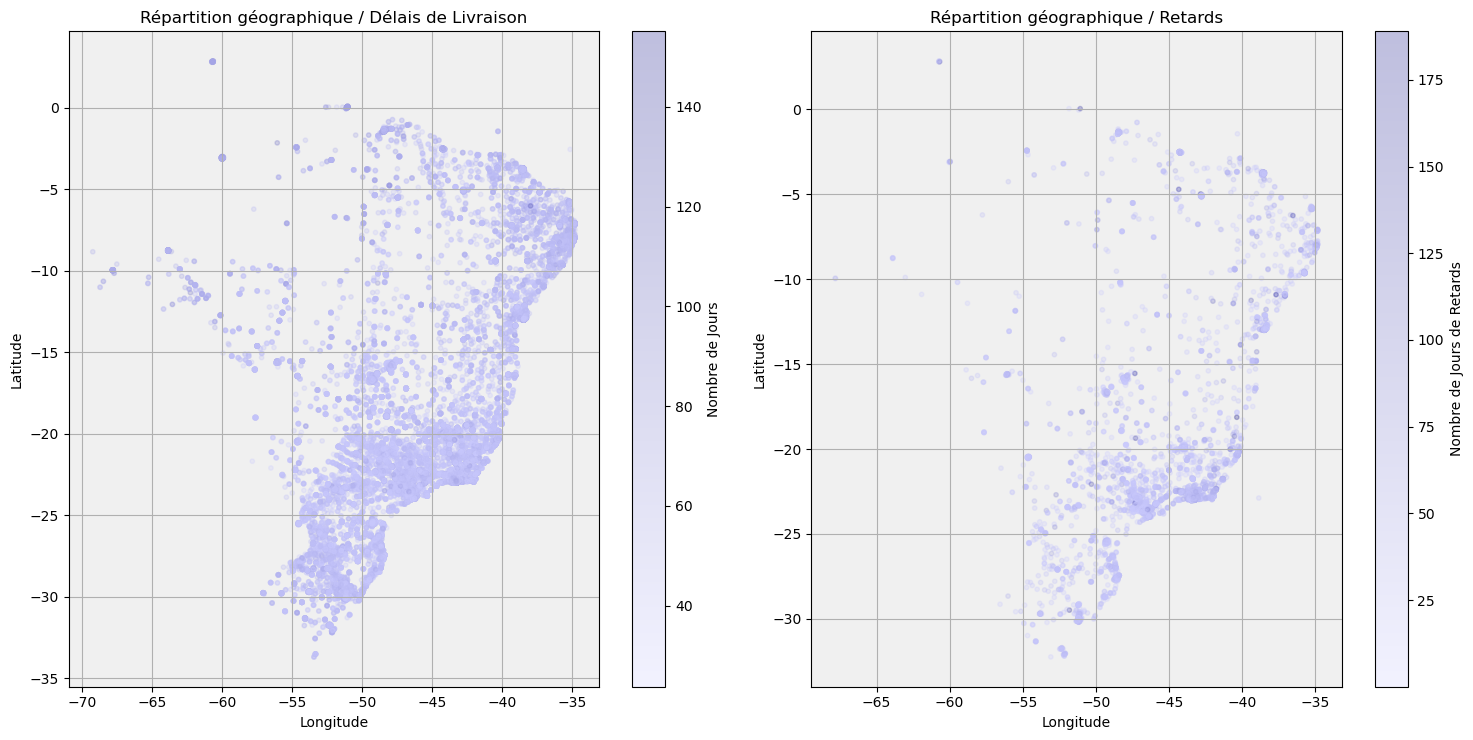

In [8]:
# Création de la figure avec une taille spécifique
plt.figure(figsize=(15, 7.5))

# Premier sous-plot : Répartition géographique / Délais de Livraison
plt.subplot(1, 2, 1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Répartition géographique / Délais de Livraison")
plt.gca().set_facecolor('#F0F0F0')

# Filtrer les données pour afficher uniquement les délais de livraison au-dessus de la moyenne
oliste = olist.loc[olist['delivery_time'] > olist['delivery_time'].mean()]

# Création du scatter plot pour les délais de livraison
scatter = plt.scatter(
    oliste['long'],
    oliste['latt'],
    c=oliste['delivery_time'],
    cmap=custom_cmap,
    alpha=0.25,
    s=10)
plt.colorbar(scatter, label='Nombre de Jours')
plt.grid()

# Deuxième sous-plot : Répartition géographique / Retards
plt.subplot(1, 2, 2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Répartition géographique / Retards")
plt.gca().set_facecolor('#F0F0F0')

# Filtrer les données pour afficher uniquement les retards
oliste = olist.loc[olist['delay'] > 0]

# Création du scatter plot pour les retards
scatter = plt.scatter(
    oliste['long'],
    oliste['latt'],
    c=oliste['delay'],
    cmap=custom_cmap,
    alpha=0.25,
    s=10)
plt.colorbar(scatter, label='Nombre de Jours de Retards')
plt.grid()

# Ajustement automatique des sous-plots pour éviter le chevauchement
plt.tight_layout()

# Affichage de la figure
plt.show()

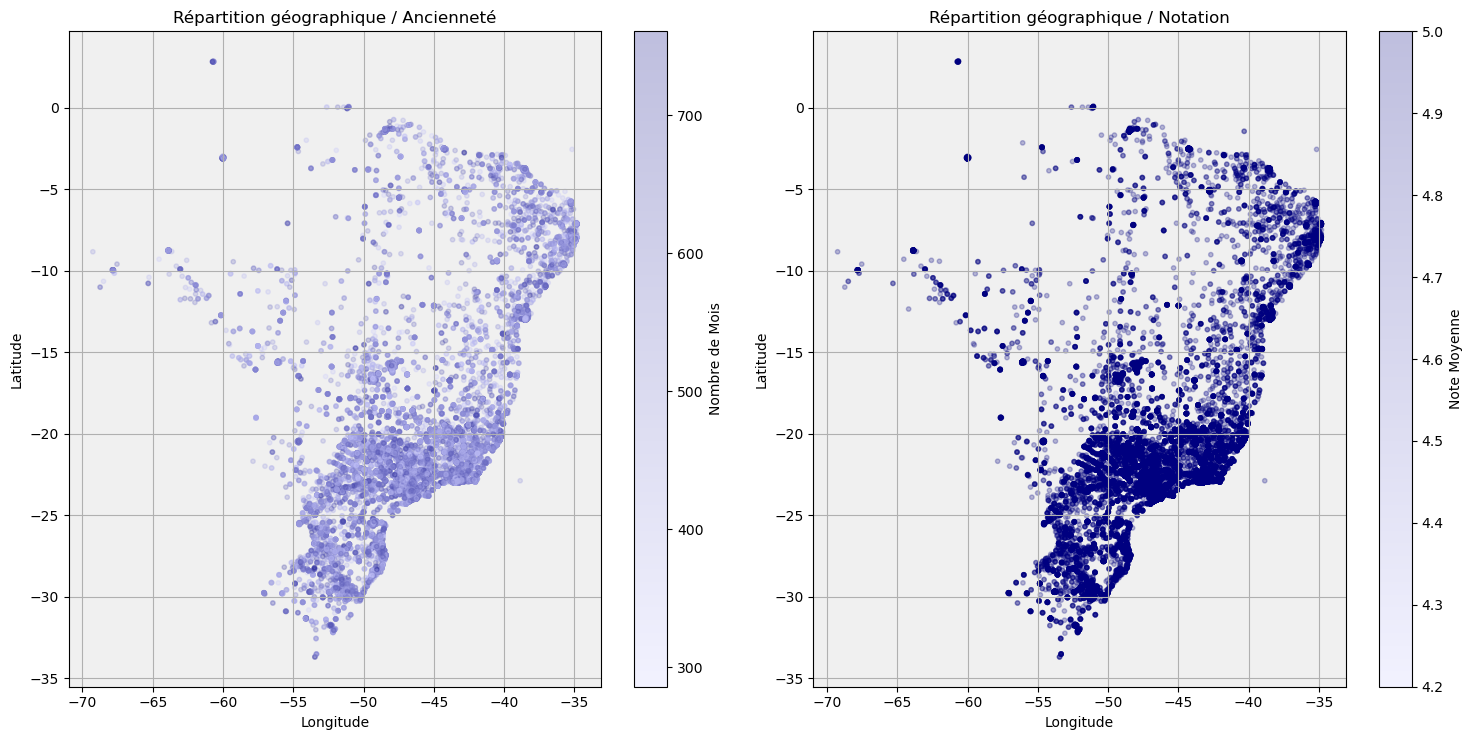

In [9]:
# Création de la figure avec une taille spécifique
plt.figure(figsize=(15, 7.5))

# Premier sous-plot : Répartition géographique / Ancienneté
plt.subplot(1, 2, 1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Répartition géographique / Ancienneté")
plt.gca().set_facecolor('#F0F0F0')

# Filtrer les données pour afficher uniquement les clients ayant une ancienneté au-dessus de la moyenne
oliste = olist.loc[
    olist['latest_purchase_numeric'] > olist['latest_purchase_numeric'].mean()]

# Création du scatter plot pour l'ancienneté
scatter = plt.scatter(
    oliste['long'],
    oliste['latt'],
    c=oliste['latest_purchase_numeric'],
    cmap=custom_cmap,
    alpha=0.25,
    s=10)
plt.colorbar(scatter, label="Nombre de Mois")
plt.grid()

# Deuxième sous-plot : Répartition géographique / Notation
plt.subplot(1, 2, 2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Répartition géographique / Notation")
plt.gca().set_facecolor('#F0F0F0')

# Filtrer les données pour afficher uniquement les clients ayant une note au-dessus de la moyenne
oliste = olist.loc[
    olist['average_score'] > olist['average_score'].mean()]

# Création du scatter plot pour la notation
scatter = plt.scatter(
    oliste['long'],
    oliste['latt'],
    c=oliste['average_score'],
    cmap=custom_cmap,
    alpha=0.25,
    s=10)
plt.colorbar(scatter, label='Note Moyenne')
plt.grid()

# Ajustement automatique des sous-plots pour éviter le chevauchement
plt.tight_layout()

# Affichage de la figure
plt.show()

Nous avons maintenant préparé et exploré les données. Les prochaines étapes consisteront à appliquer différentes techniques de segmentation et à évaluer leur pertinence pour répondre aux besoins de segmentation client d'Olist. Pour cela, merci de vous référer au note suivant : "Martineau_Alexandre_3_notebook_essais_072024.ipynb"